In [3]:
with open("attention_results/20240528_115802_attention.txt", "r") as file:
    contents = file.read()
    print(contents)

Generated token index: 0, decoder element 0 shape: torch.Size([1, 32, 769, 769])
Generated token index: 0, decoder element 1 shape: torch.Size([1, 32, 769, 769])
Generated token index: 0, decoder element 2 shape: torch.Size([1, 32, 769, 769])
Generated token index: 0, decoder element 3 shape: torch.Size([1, 32, 769, 769])
Generated token index: 0, decoder element 4 shape: torch.Size([1, 32, 769, 769])
Generated token index: 0, decoder element 5 shape: torch.Size([1, 32, 769, 769])
Generated token index: 0, decoder element 6 shape: torch.Size([1, 32, 769, 769])
Generated token index: 0, decoder element 7 shape: torch.Size([1, 32, 769, 769])
Generated token index: 0, decoder element 8 shape: torch.Size([1, 32, 769, 769])
Generated token index: 0, decoder element 9 shape: torch.Size([1, 32, 769, 769])
Generated token index: 0, decoder element 10 shape: torch.Size([1, 32, 769, 769])
Generated token index: 0, decoder element 11 shape: torch.Size([1, 32, 769, 769])
Generated token index: 0, 

In [7]:
import json

with open("attention_results/20240528_124840_attention_weights.json", "r") as file:
    attention_description = json.load(file)

    # Remove the 'attention_description' key if it exists
    if 'attention_description' in attention_description:
        del attention_description['attention_description']

    # Display the content of the JSON file nicely
    import pprint

    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(attention_description)


{   'image_features': [1, 729, 2560],
    'image_tensor': [1, 3, 384, 384],
    'input_ids': [1, 41],
    'inputs_embeds': [1, 769, 2560],
    'outputs': 'In the image, there are two cats, one gray and one brown, '
               'comfortably resting on a pink blanket. The gray cat is lying '
               'on its side, with its head resting on the blanket, while the '
               'brown cat is lying on its stomach, also with its head on the '
               'blanket. The pink blanket they are lying on is spread out on a '
               'red couch. In the background, there are two remote controls, '
               'one blue and one white, placed on the couch. The cats seem to '
               'be enjoying their time on the couch, oblivious to their '
               'surroundings.',
    'post_mm_projector': [1, 729, 2560],
    'post_vision_tower_encoding': [1, 729, 1152],
    'prompt': 'A chat between a curious human and an artificial intelligence '
              'assistant. The as

In [2]:
import torch

# Load the attention results from the specified file
attention_results_path = "attention_results/attentions.pt"
attentions = torch.load(attention_results_path, map_location=torch.device('cpu'))

# Print the loaded attentions to verify
print(attentions)


((tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.6274e-02, 9.4385e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.1011e-02, 2.3132e-01, 7.4756e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [9.1791e-06, 5.9605e-08, 8.9407e-07,  ..., 4.0100e-02,
           0.0000e+00, 0.0000e+00],
          [1.2913e-03, 5.7817e-05, 5.4955e-05,  ..., 8.7036e-02,
           2.1680e-01, 0.0000e+00],
          [6.9439e-05, 2.9802e-06, 5.1856e-06,  ..., 1.4526e-01,
           1.0486e-01, 3.2227e-01]],

         [[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.9604e-01, 8.0371e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4038e-02, 8.9941e-01, 8.6304e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.5898e-03, 3.6502e-04, 2.9564e-04,  ..., 5.60

In [69]:
import numpy as np

decoder_no = 1
attention_head = 25

final_size = attentions[-1][decoder_no][0,attention_head,:].shape[1]
attention_matrix = np.zeros((final_size, final_size))

first_matrix = np.array(attentions[0][decoder_no][0,attention_head,:])
first_matrix_height = first_matrix.shape[0]

# Insert the first_matrix into the top left corner of attention_matrix
attention_matrix[:first_matrix.shape[0], :first_matrix.shape[1]] = first_matrix


for generated_token_index, attention in enumerate(attentions[1:], start=0):
    new_token_row = np.array(attention[decoder_no][0, attention_head, :])
    new_token_row = np.pad(new_token_row, ((0, 0), (0, final_size - new_token_row.shape[1])), 'constant')

    attention_matrix[first_matrix_height + generated_token_index] = new_token_row

    # Select only the first batch and the first attention head
    # output_text = f"Generated token index: {generated_token_index}, decoder element 0 shape: {decoder_element.shape}"
    # decoder_element_np = decoder_element.numpy()
    
    # print(output_text)

is_lower_triangular = np.allclose(attention_matrix, np.tril(attention_matrix))
print(f"Is this a lower triangular matrix? {is_lower_triangular}")


Is this a lower triangular matrix? True


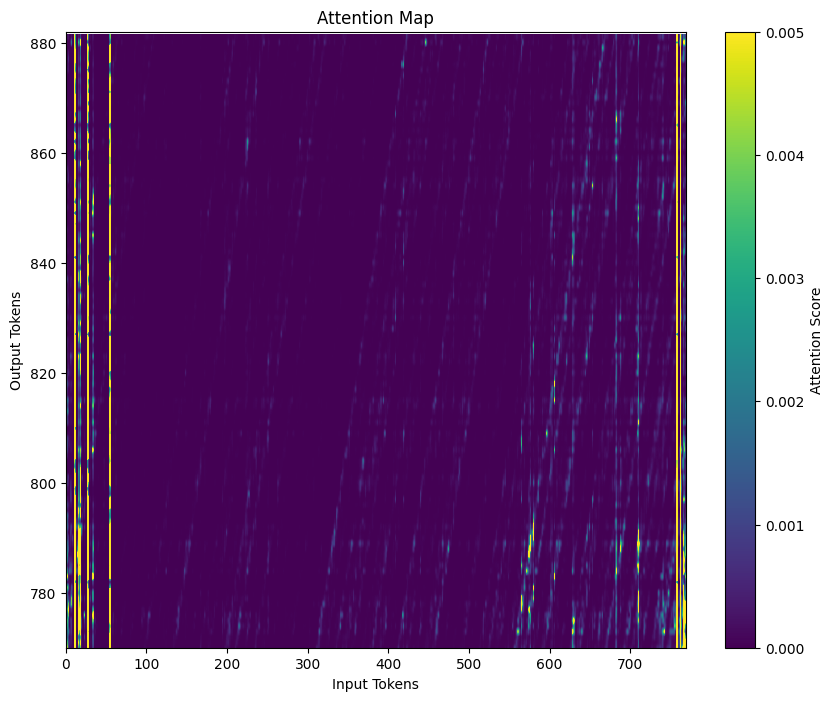

In [70]:
import matplotlib.pyplot as plt

# Visualize the attention matrix on a smaller scale
plt.figure(figsize=(10, 8))
plt.imshow(attention_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=0.005)
plt.colorbar(label='Attention Score')
plt.ylabel('Output Tokens')
plt.xlabel('Input Tokens')
plt.title('Attention Map')
plt.ylim(770, 882)  # Limit the y-axis to 770 to 882
plt.xlim(0, 769)  # Limit the x-axis to 769
plt.show()
